In [1]:
import pandas as pd
df = pd.read_excel("DelhiData.xlsx")
df

,Timestamp,PM2.5,PM10,NO,NO2,Nox,NH3,SO2,CO,Ozone
0,2019-01-01,407.940000,570.860000,65.110000,101.130000,146.550000,73.490000,23.840000,3.040000,20.630000
1,2019-01-02,465.070000,631.640000,89.800000,117.330000,176.840000,85.190000,22.920000,3.690000,21.330000
2,2019-01-03,437.710000,605.650000,37.790000,90.990000,108.140000,98.900000,19.090000,3.150000,19.140000
3,2019-01-04,313.420000,510.710000,38.950000,73.050000,70.530000,77.680000,13.030000,3.110000,10.260000
4,2019-01-05,295.880000,502.120000,62.660000,78.750000,89.640000,72.410000,17.260000,3.150000,21.270000
...,...,...,...,...,...,...,...,...,...,...
1821,2023-12-27,334.295139,511.760417,38.460417,80.719792,74.260417,166.193750,11.948264,2.222222,12.253125
1822,2023-12-28,226.791667,379.437500,21.444792,59.698958,49.198958,134.685417,11.919792,1.601389,15.066667
1823,2023-12-29,316.347222,524.250000,30.773148,75.799537,65.405093,124.455556,13.750926,2.145370,21.607407
1824,2023-12-30,255.302083,418.541667,16.255208,67.660417,49.227083,104.310764,14.146181,1.849306,20.296875


In [2]:
import pandas as pd

# Convert Timestamp to datetime and set as index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)


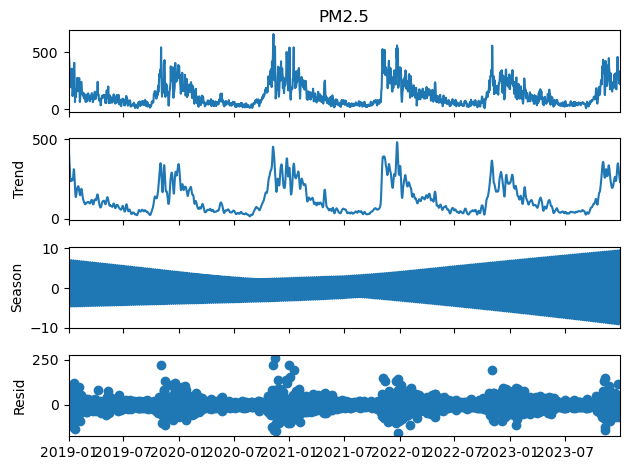

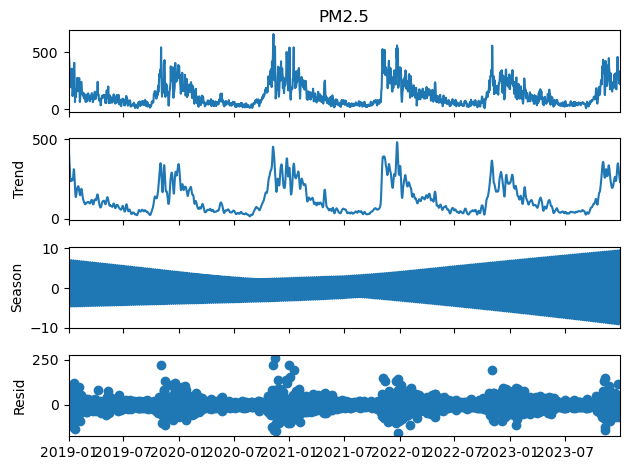

In [3]:
from statsmodels.tsa.seasonal import STL

# STL decomposition
stl = STL(df['PM2.5'], seasonal=365)
result = stl.fit()

# Plotting components
result.plot()


In [7]:
for pollutant in ['PM2.5', 'PM10', 'NO', 'NO2', 'Nox', 'NH3', 'SO2', 'CO', 'Ozone']:
    df[f'{pollutant}_lag1'] = df[pollutant].shift(1)
    df[f'{pollutant}_7d_avg'] = df[pollutant].rolling(window=7).mean()


In [9]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


In [1]:
pip install pmdarima


Note: you may need to restart the kernel to use updated packages.


In [11]:
# Find the differencing order (d) specifically for the PM2.5 series
d = find_differencing_order(df['PM2.5'])
print(f"Recommended differencing order (d) for PM2.5 series: {d}")


NameError: name 'find_differencing_order' is not defined

In [12]:
from statsmodels.tsa.stattools import adfuller

def find_differencing_order(series, significance_level=0.05):
    """
    Function to determine the differencing order (d) needed for stationarity.
    Args:
        series (pd.Series): The time series data to be tested.
        significance_level (float): The p-value threshold for stationarity.
    Returns:
        int: The differencing order (d).
    """
    d = 0
    p_value = adfuller(series.dropna())[1]
    
    # Increment differencing order until p-value < significance_level
    while p_value > significance_level:
        d += 1
        differenced_series = series.diff(d).dropna()
        p_value = adfuller(differenced_series)[1]
        print(f'Differencing order d={d}, ADF p-value={p_value}')
    
    print(f"Optimal differencing order for stationarity: d = {d}")
    return d

# Apply the function to the PM2.5 column in your DataFrame
d = find_differencing_order(df['PM2.5'])
print(f"Recommended differencing order (d) for PM2.5 series: {d}")


Optimal differencing order for stationarity: d = 0
Recommended differencing order (d) for PM2.5 series: 0


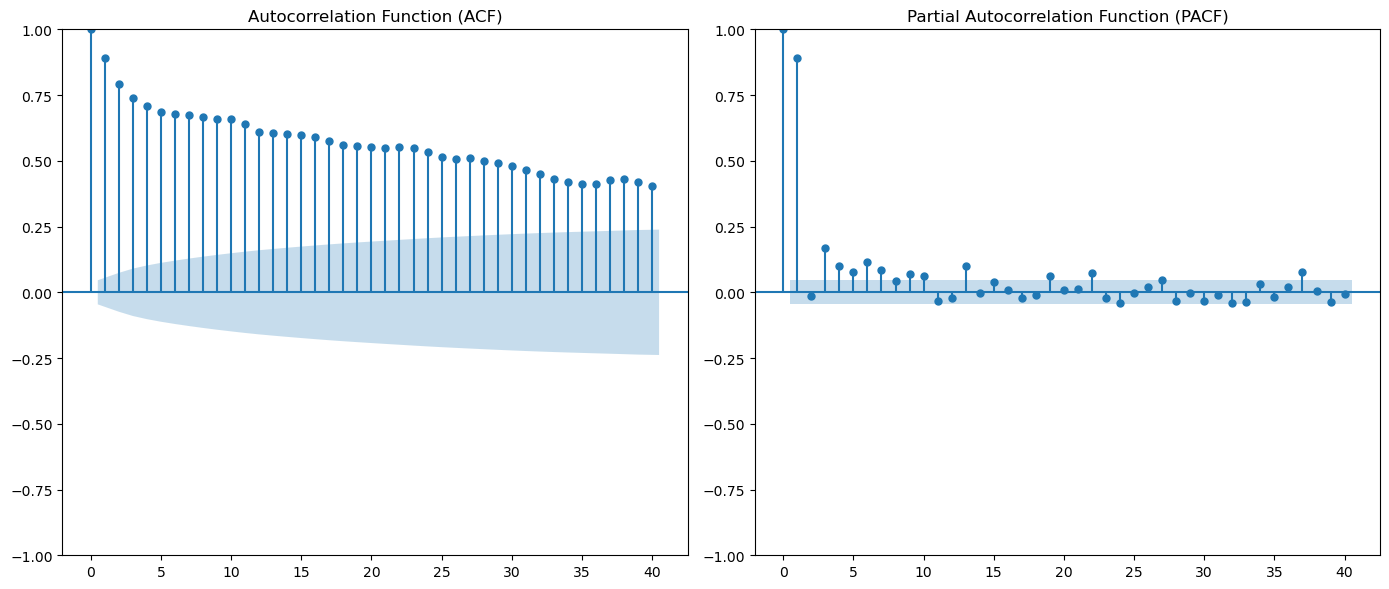

In [19]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags=40):
    """
    Plots the ACF and PACF for a given time series.
    Args:
        series (pd.Series): The time series data.
        lags (int): Number of lags to display in the plot.
    """
    plt.figure(figsize=(14, 6))

    # Plot ACF
    plt.subplot(1, 2, 1)
    plot_acf(series.dropna(), lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')

    # Plot PACF
    plt.subplot(1, 2, 2)
    plot_pacf(series.dropna(), lags=lags, ax=plt.gca(), method='ywm')
    plt.title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

# Plot ACF and PACF for the PM2.5 series
plot_acf_pacf(df['PM2.5'])


In [11]:
import statsmodels.api as sm

# Define a function to fit and print summary for each ARIMA model
def fit_arima_models(series):
    # List of ARIMA models to test
    model_configs = [
        (2, 0, 2, 0, 0, 0, 52),
        (3, 0, 1, 0, 0, 0, 52),
        (2, 0, 3, 0, 0, 0, 52),
        (3, 0, 2, 0, 0, 0, 52)
    ]
    
    # Fit each model and print results
    for config in model_configs:
        p, d, q, P, D, Q, s = config
        print(f"\nFitting ARIMA({p},{d},{q})({P},{D},{Q})[{s}] model...")
        
        # Fit the model
        model = sm.tsa.statespace.SARIMAX(
            series,
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        
        # Print model summary
        print(results.summary())
        
# Use the PM2.5 series to fit the models
fit_arima_models(df['PM2.5'])



Fitting ARIMA(2,0,2)(0,0,0)[52] model...


C:\Users\Sahil Rafaliya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sahil Rafaliya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1826
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -9506.306
Date:                Sun, 10 Nov 2024   AIC                          19022.612
Time:                        18:49:11   BIC                          19050.153
Sample:                    01-01-2019   HQIC                         19032.772
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4762      0.031     47.077      0.000       1.415       1.538
ar.L2         -0.4782      0.031    -15.359      0.000      -0.539      -0.417
ma.L1         -0.6301      0.031    -20.209      0.0

C:\Users\Sahil Rafaliya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sahil Rafaliya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1826
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -9505.571
Date:                Sun, 10 Nov 2024   AIC                          19021.142
Time:                        18:49:12   BIC                          19048.683
Sample:                    01-01-2019   HQIC                         19031.302
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7018      0.020     83.831      0.000       1.662       1.742
ar.L2         -0.8682      0.027    -31.790      0.000      -0.922      -0.815
ar.L3          0.1645      0.015     10.961      0.0

C:\Users\Sahil Rafaliya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sahil Rafaliya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1826
Model:               SARIMAX(2, 0, 3)   Log Likelihood               -9498.457
Date:                Sun, 10 Nov 2024   AIC                          19008.914
Time:                        18:49:14   BIC                          19041.960
Sample:                    01-01-2019   HQIC                         19021.105
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4147      0.064     22.071      0.000       1.289       1.540
ar.L2         -0.4169      0.064     -6.545      0.000      -0.542      -0.292
ma.L1         -0.5676      0.065     -8.727      0.0

C:\Users\Sahil Rafaliya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sahil Rafaliya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1826
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -9505.615
Date:                Sun, 10 Nov 2024   AIC                          19023.230
Time:                        18:49:16   BIC                          19056.279
Sample:                    01-01-2019   HQIC                         19035.422
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6151      0.097     16.599      0.000       1.424       1.806
ar.L2         -0.7226      0.163     -4.447      0.000      -1.041      -0.404
ar.L3          0.1056      0.067      1.576      0.1

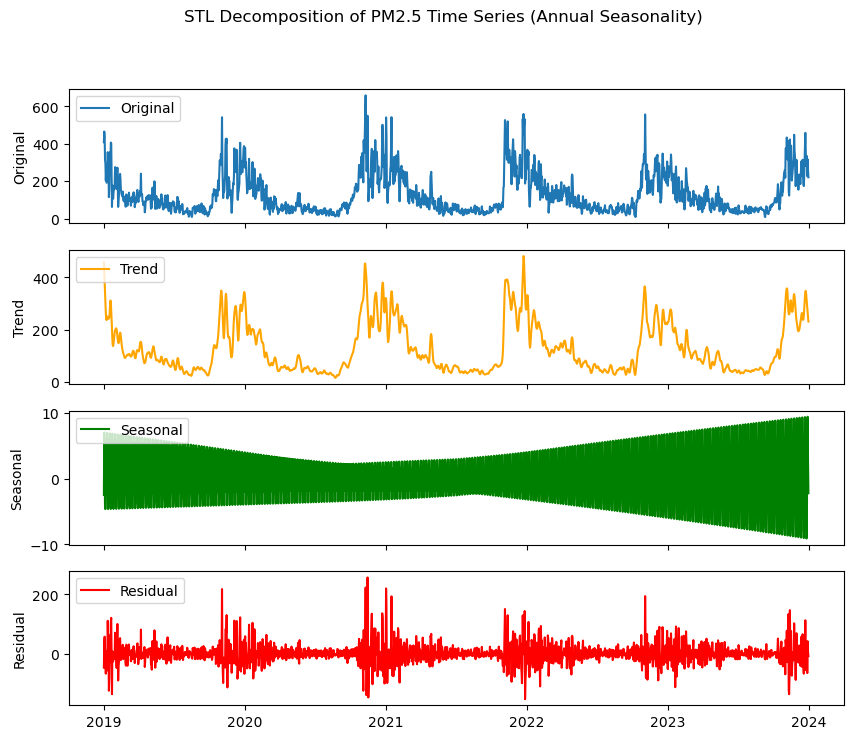

In [15]:
import matplotlib.pyplot as plt
# Updated STL Decomposition with annual seasonality and custom plot settings
stl = sm.tsa.STL(df['PM2.5'], seasonal=365)
stl_result = stl.fit()

# Plotting with larger figure size and titles for clarity
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
fig.suptitle('STL Decomposition of PM2.5 Time Series (Annual Seasonality)')

# Original, Trend, Seasonal, and Residual components
ax1.plot(df['PM2.5'], label='Original')
ax1.legend(loc='upper left')
ax1.set_ylabel('Original')

ax2.plot(stl_result.trend, label='Trend', color='orange')
ax2.legend(loc='upper left')
ax2.set_ylabel('Trend')

ax3.plot(stl_result.seasonal, label='Seasonal', color='green')
ax3.legend(loc='upper left')
ax3.set_ylabel('Seasonal')

ax4.plot(stl_result.resid, label='Residual', color='red')
ax4.legend(loc='upper left')
ax4.set_ylabel('Residual')

plt.show()


ADF Statistic: -3.233642
p-value: 0.018118
Critical Values:
  1%: -3.4339840952648695
  5%: -2.8631452508003057
  10%: -2.567624583142913


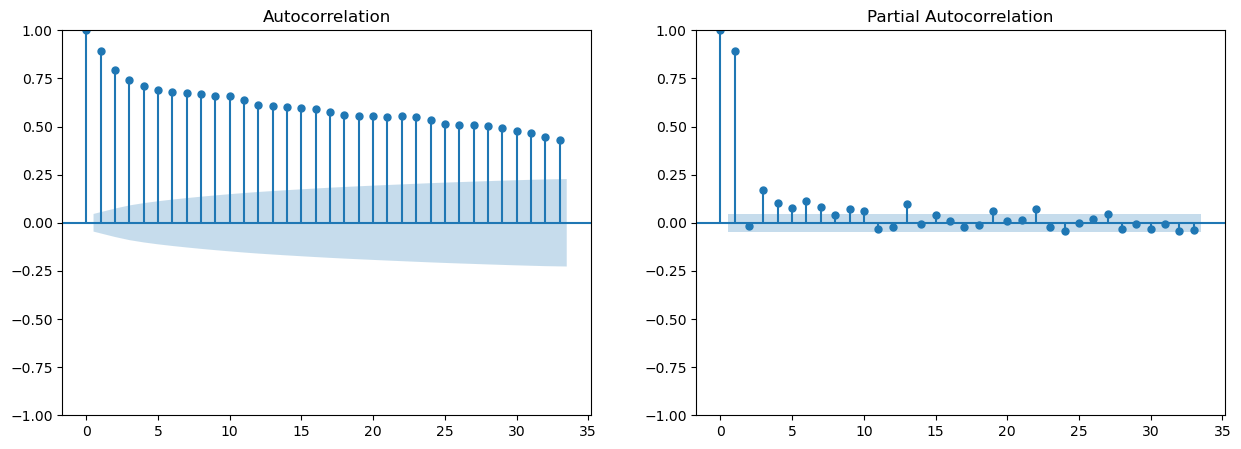

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming df is your DataFrame with the 'PM2.5' column containing the time series data

# ADF Test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value}')

# Plot ACF and PACF
def plot_acf_pacf(series):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(series, ax=axes[0])
    plot_pacf(series, ax=axes[1])
    plt.show()

# Example usage:
# Check the ADF test for the PM2.5 column
adf_test(df['PM2.5'])

# Plot ACF and PACF
plot_acf_pacf(df['PM2.5'])


In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA model
model = SARIMAX(df['PM2.5'], order=(1, 0, 0), seasonal_order=(1, 1, 1, 54))
model_fit = model.fit()

# Print model summary to check performance
print(model_fit.summary())


C:\Users\Sahil Rafaliya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sahil Rafaliya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                PM2.5   No. Observations:                 1826
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 54)   Log Likelihood               -9396.177
Date:                              Sun, 10 Nov 2024   AIC                          18800.354
Time:                                      19:21:13   BIC                          18822.274
Sample:                                  01-01-2019   HQIC                         18808.452
                                       - 12-31-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8972      0.006    150.291      0.000       0.886       0.909
ar.S.L54       0.02

In [ ]:
from sklearn.metrics import r2_score

# y_true: Actual values
# y_pred: Predicted values from the model
r2 = r2_score(train,test)

print("R2 Score:", r2)


C:\Users\Sahil Rafaliya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sahil Rafaliya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sahil Rafaliya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sahil Rafaliya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sahil Rafaliya\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, 

Best Parameters: (2, 1, 1, 1, 1, 1, 12)
Best AIC: 18235.809388642265


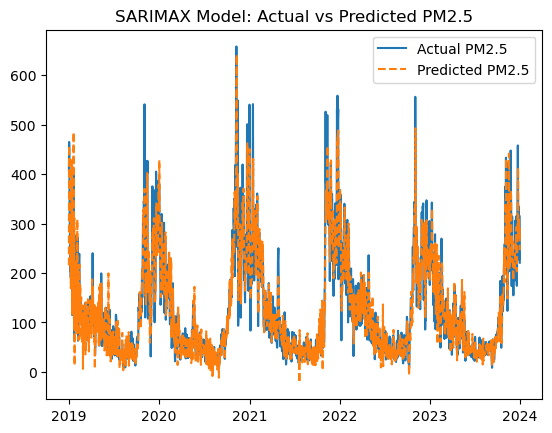

RMSE: 37.863205021495844


In [29]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools
import matplotlib.pyplot as plt

# Preprocess the data
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Choose the target variable (e.g., 'PM2.5') and exogenous variables (e.g., 'NO', 'CO', 'Ozone')
y = df['PM2.5']  # Target variable
X = df[['NO', 'CO', 'Ozone']]  # Exogenous variables (adjust based on your needs)

# Define a function for SARIMAX model fitting and AIC calculation
def sarimax_grid_search(y, X=None, seasonal_period=12):
    # Define the parameter grid
    p_values = [0, 1, 2]  # AR terms
    d_values = [0, 1]     # Differencing terms
    q_values = [0, 1, 2]  # MA terms
    P_values = [0, 1, 2]  # Seasonal AR terms
    D_values = [0, 1]     # Seasonal differencing
    Q_values = [0, 1, 2]  # Seasonal MA terms
    S_values = [seasonal_period]  # Seasonal period (e.g., 12 for monthly data with yearly seasonality)

    # Grid of all parameter combinations
    param_grid = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, S_values))
    
    # Initialize variables to store the best results
    best_aic = np.inf
    best_params = None
    best_model = None
    best_predictions = None

    for params in param_grid:
        p, d, q, P, D, Q, S = params
        
        try:
            # Fit the SARIMAX model
            model = SARIMAX(y, exog=X, order=(p, d, q), seasonal_order=(P, D, Q, S))
            result = model.fit(disp=False)
            
            # Get the AIC score
            aic = result.aic
            
            # Check if we have a better AIC (lower is better)
            if aic < best_aic:
                best_aic = aic
                best_params = params
                best_model = result
                best_predictions = result.predict(start=len(y)-len(X), end=len(y)-1, exog=X)
        
        except Exception as e:
            # In case the model does not converge or fails to fit
            print(f"Model with params {params} failed. Error: {e}")
            continue
    
    # Return the best model and the associated parameters
    return best_model, best_params, best_aic, best_predictions

# Call the function with your time series data
best_model, best_params, best_aic, best_predictions = sarimax_grid_search(y, X)

# Print the best parameters and the AIC score
print(f"Best Parameters: {best_params}")
print(f"Best AIC: {best_aic}")

# Plot the predictions vs actual values
plt.plot(y, label='Actual PM2.5')
plt.plot(best_predictions, label='Predicted PM2.5', linestyle='--')
plt.legend()
plt.title('SARIMAX Model: Actual vs Predicted PM2.5')
plt.show()

# Optionally, calculate error metrics on the test data
# For example: Mean Squared Error (MSE) or Root Mean Squared Error (RMSE)
mse = mean_squared_error(y[-len(best_predictions):], best_predictions)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")


In [ ]:
import pandas as pd
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools

# Suppress warnings
warnings.filterwarnings("ignore")

# Load your time series data (ensure the 'PM2.5' column is used for modeling)
# df = pd.read_csv('your_data.csv')  # Uncomment if reading from a CSV
y = df['PM2.5']

# Define the p, d, q and seasonal P, D, Q ranges
p = d = q = range(0, 3)  # Test values 0, 1, 2 for p, d, q
pdq = list(itertools.product(p, d, q))

# Define the seasonal order range
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # Assuming monthly seasonality (S=12)

# Grid search over parameter combinations
best_aic = float("inf")
best_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Fit SARIMA model with given parameters
            model = SARIMAX(y,
                            order=param,
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit()
            
            # Check if the model's AIC is the best
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, param_seasonal)
            
            print(f"SARIMA{param}x{param_seasonal} - AIC:{results.aic}")
        
        except Exception as e:
            continue

# Display the best parameters
print(f"\nBest SARIMA model: SARIMA{best_params[0]}x{best_params[1]} - AIC:{best_aic}")


SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:23793.476870116807
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:22578.31880009477
SARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:21801.52803693238
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:21417.22434055729
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:20902.203143088802
SARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:20749.379888515206
SARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:23107.674545444785
SARIMA(0, 0, 0)x(0, 2, 1, 12) - AIC:21156.009631359913
SARIMA(0, 0, 0)x(0, 2, 2, 12) - AIC:20706.72193543973
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:21291.785107514203
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:21043.776120584524
SARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:20862.745972777942
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:20941.996609667243
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:20896.429016212824
SARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:20749.555226163022
SARIMA(0, 0, 0)x(1, 2, 0, 12) - AIC:21896.273296024523
SARIMA(0, 0, 0)x(1, 2, 1, 12) - AIC:20859.74702402209
SARIMA(0, 0, 0)x(1, 2, 2, 12) - AIC:20691.501331563413
SARIMA(0, 0, 0)